# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 04**: Data Unions & Joins Pipeline

**Date**: September 23rd 2025

**Student Name**:

**Professor**: Pablo Camarillo Ramirez

## Create Spark session

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://f0e377311925:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/26 13:26:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
!pwd

/opt/spark/work-dir/labs/lab04


## Create data frames

In [3]:
# Build schema
# Import your module
from sergiovillaa.spark_utils import SparkUtils
from pyspark.sql.functions import get_json_object

agencies_schema = SparkUtils.generate_schema([("agency_id", "string"), ("agency_info", "string")])
cars_schema = SparkUtils.generate_schema([("car_id", "int"), ("car_info", "string")])
customers_schema = SparkUtils.generate_schema([("customer_id", "int"), ("customer_info", "string")])
rental_cars_schema = SparkUtils.generate_schema([("rental_id", "int"), ("rental_info", "string")])

base_path = "/opt/spark/work-dir/data/"

agencies_df = spark.read \
                .schema(agencies_schema) \
                .option("header", "true") \
                .csv(base_path + "car_service/car_service/agencies")
agencies_df = agencies_df.withColumn("agency_name", get_json_object(agencies_df.agency_info, "$.agency_name"))


cars_df = spark.read.option("header", "true").schema(cars_schema).csv(base_path + "car_service/car_service/cars")

brands_df = spark.read.option("header", "true").schema(cars_schema).csv(base_path + "car_service/car_service/brands")

customers_df = spark.read.option("header", "true").schema(customers_schema).csv(base_path + "car_service/car_service/customers")

rental_cars_df = spark.read.option("header", "true").schema(rental_cars_schema).csv(base_path + "car_service/car_service/rentals")

## Extract JSON info

In [4]:
agencies_df = agencies_df.withColumn("agency_name", get_json_object(agencies_df.agency_info, "$.agency_name")).drop("agency_info")
cars_df = cars_df.withColumn("car_name", get_json_object(cars_df.car_info, "$.car_name")).drop("car_info")
customers_df = customers_df.withColumn("customer_name", get_json_object(customers_df.customer_info, "$.customer_name")).drop("customer_info")

rental_cars_df = rental_cars_df.withColumn("car_id", get_json_object(rental_cars_df.rental_info, '$.car_id')) \
                            .withColumn("customer_id", get_json_object(rental_cars_df.rental_info, '$.customer_id')) \
                            .withColumn("agency_id", get_json_object(rental_cars_df.rental_info, '$.agency_id')) \
                            .drop("rental_info")

## Join transformations

In [5]:
rental_cars_df = rental_cars_df.join(cars_df, on="car_id", how="left") \
                                .join(customers_df, on="customer_id", how="left") \
                                .join(agencies_df, on="agency_id", how="left") \
                                .drop("agency_id", "customer_id", "car_id")

rental_cars_df.show(5)

+---------+--------------------+---------------+-------------+
|rental_id|            car_name|  customer_name|  agency_name|
+---------+--------------------+---------------+-------------+
|    11891|Wallace-Carlson M...| Margaret Jones|  NYC Rentals|
|    11892|Grimes-Green Model 8|Albert Williams|LA Car Rental|
|    11893|Stewart-Allen Mod...|  Caleb Fleming|      SF Cars|
|    11894|  Campos PLC Model 4|  Andrew Butler|  NYC Rentals|
|    11895|  Wagner LLC Model 1|  Kristin Potts|      SF Cars|
+---------+--------------------+---------------+-------------+
only showing top 5 rows


## Persist data

### Parquet file

In [18]:
!pwd

/opt/spark/work-dir/labs/lab04


In [19]:
rental_cars_df.write \
            .partitionBy("agency_name") \
            .mode("overwrite") \
            .parquet(base_path + "car_service/car_service/output/parquet")

In [28]:
!du -sh ../../data/car_service/car_service/output/parquet

144K	../../data/car_service/car_service/output/parquet


### CSV files

In [29]:
rental_cars_df.write \
            .partitionBy("agency_name") \
            .mode("overwrite") \
            .option("header", True) \
            .csv(base_path + "car_service/car_service/output/csv")

In [36]:
!ls ../../data/car_service/car_service/output/csv

'agency_name=LA Car Rental'  'agency_name=SF Cars'	  _SUCCESS
'agency_name=NYC Rentals'    'agency_name=Zapopan Auto'


In [35]:
!du -sh ../../data/car_service/car_service/output/csv

856K	../../data/car_service/car_service/output/csv


In [10]:
rental_cars_df.write \
            .mode("overwrite") \
            .option("header", True) \
            .csv(base_path + "car_service/car_service/output/rentals/csv")

In [11]:
rental_cars_df.write \
            .mode("overwrite") \
            .parquet(base_path + "car_service/car_service/output/rentals/parquet")

In [12]:
airlines_schema_columns = [("index", "int"), 
     ("airline", "string"), 
     ("flight", "string"),
     ("source_city", "string"),
     ("departure_time", "string"),
     ("stops", "string"),
     ("arrival_time", "string"),
     ("destination_city", "string"),
     ("class", "string"),
     ("duration", "float"),
     ("days_left", "int"),
     ("price", "int")
     ]
airlines_schema = SparkUtils.generate_schema(airlines_schema_columns)

df_airlines = spark.read \
                .option("header", "true") \
                .schema(airlines_schema) \
                .csv(base_path + "/airline/")

from pyspark.sql.functions import max, min
df_airlines.groupBy(df_airlines.airline).agg(max(df_airlines.price), min(df_airlines.price)).show()

[Stage 28:=============================>                            (1 + 1) / 2]

+---------+----------+----------+
|  airline|max(price)|min(price)|
+---------+----------+----------+
|   Indigo|     31952|      1105|
| SpiceJet|     34158|      1106|
|Air_India|     90970|      1526|
|  AirAsia|     31917|      1105|
| GO_FIRST|     32803|      1105|
|  Vistara|    123071|      1714|
+---------+----------+----------+



In [13]:
df_final = df_airlines.filter(df_airlines.price < 1500)
df_final.count()

501

In [14]:
df_final.write \
              .option("header", True) \
              .mode("overwrite") \
              .csv(base_path + "/airline/output/csv")

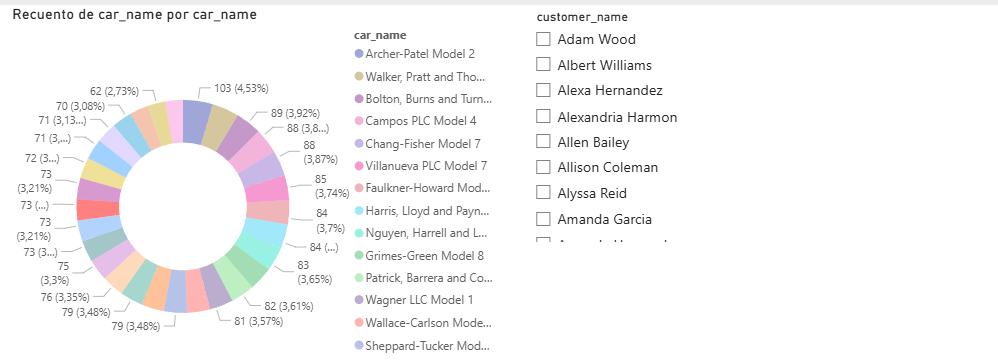

In [1]:
sc.stop()

NameError: name 'sc' is not defined